In [47]:
# load dependencies
from data import *
    
##################################################################################################################
######################################### RUN RFM FOR EARTH  #####################################################
##################################################################################################################

# Step 0: Define the case and the resolution
class parameters:
    def __init__(self,**params):
        # Spectral resolution used in RFM experiments
        self.nu0 = params.get('nu0', 1)  # cm-1
        self.nu1 = params.get('nu1', 1500)  # cm-1
        self.dnu = params.get('dnu', 0.1)  # cm-1
        self.band = params.get('band', 'earth')
        self.runtype = params.get('runtype', 'cooling')
        self.cpdef = params.get('cp', 29012 / 28.964)  # J/kg/K (default RFM value of specific heat)
        self.nsday = params.get('nsday', 86400)  # seconds per Earth-day
        self.TEMREL = params.get('TEMREL', 0)  # ground-air temp diff.

        # spectral range calculations
        self.nus = np.arange(self.nu0, self.nu1 + self.dnu, self.dnu)
        if self.band == 'earth':
            self.i0 = np.squeeze(np.where(np.abs(self.nus - self.nu0) == np.min(np.abs(self.nus - self.nu0))))
            self.i1 = np.squeeze(np.where(np.abs(self.nus - self.nu1) == np.min(np.abs(self.nus - self.nu1))))
        else:
            raise ValueError(f"Invalid band type: {self.band}. Expected 'earth'.")
        self.nnus = len(self.nus)

        # Thermodynamic parameters
        self.ps = params.get('ps', 1e5)
        self.Ts = params.get('Ts', 300)
        self.Ttrp = params.get('Ttrp', 200)
        self.Gamma = params.get('Gamma', 6.5e-3)
        self.z = params.get('z', np.arange(0, 3e4, 1))

        # Saturation Vapor Pressure (Water Vapor)
        self.Ttrip = params.get('Ttrip', 273.16)  # K 
        self.ptrip = params.get('ptrip', 611.65)  # Pa
        self.E0v   = params.get('E0v', 2.3740e6)  # J/kg 
        self.ggr   = params.get('ggr', 9.81)      # m/s^2, gravity
        self.rgasa = params.get('rgasa', 287.04)  # J/kg/K, specific gas constant of dry air
        self.rgasv = params.get('rgasv', 461.5)   # J/kg/K, specific gas constant of water vapor
        self.cva   = params.get('cva', 719)       # J/kg/K, isovolumetric specific heat of dry air
        self.cvv   = params.get('cvv', 1418)      # J/kg/K, isovolumetric specific heat of water vapor
        self.cvl   = params.get('cvl', 4119)      # J/kg/K, isovolumetric specific heat of liquid water
        self.cpa   = params.get('cpa', self.cva + self.rgasa)   # isobaric specific heat of dry air
        self.cpv   = params.get('cpv', self.cvv + self.rgasv)   # isobaric specific heat of water vapor
        self.eps   = params.get('eps', self.rgasa / self.rgasv) # ratio of specific gas constants
        self.L     = params.get('L', 2.5e6)       # enthalpy of vaporization of water
        self.E0s   = params.get('E0s', np.nan)    # no ice phase
        self.cvs   = params.get('cvs', np.nan)    # no ice phase
           
        # Earth-like composition parameters
        self.Runi  = params.get('Runi',8.314)               # universal gas constant (J/mol/K)
        self.MN2   = params.get('MN2',2*14.01*1e-3)         # molecular weight of N2 (kg/mol)
        self.MO2   = params.get('MO2',2*15.999*1e-3)        # molecular weight of O2 (kg/mol)
        self.MH2O  = params.get('MH2O',18.015*1e-3)         # molecular weight of H2O (kg/mol)
        self.MCO2  = params.get('MCO2',44.009*1e-3)         # molecular weight of CO2 (kg/mol)
        self.RN2   = params.get('RN2',self.Runi/self.MN2)   # specific gas constant of N2 (J/kg/K)
        self.RO2   = params.get('RO2',self.Runi/self.MO2)   # specific gas constant of O2 (J/kg/K)
        self.RH2O  = params.get('RH2O',self.Runi/self.MH2O) # specific gas constant of H2O (J/kg/K)
        self.RCO2  = params.get('RCO2',self.Runi/self.MCO2) # specific gas constant of CO2 (J/kg/K)
        
        # Earth-like molar mixing ratios
        self.xCO2  = params.get('xCO2',395e-6)              # molar mixing ratio of CO2 (mol/mol) ~ 395 ppmv
        self.xN2   = params.get('xN2',0.78)            # molar mixing ratio of N2 (mol/mol) 
        self.xO2   = params.get('xO2',0.22)            # molar mixing ratio of O2 (mol/mol)  
           
        # Initialize case string
        self.case = ""
        
    def generate_case(self,**params):
        planet       = params.get('planet','unknown')
        self.RHs     = params.get('RHs',0.75)
        self.RHmid   = params.get('RHmid',0.54)
        self.RHtrp   = params.get('RHtrp',0.75)
        self.Tmid    = params.get('Tmid',250)
        self.uniform = params.get('uniform',1)
        # Extract gases dynamically (gas1, gas2, ..., gasN)
        gases = [params[key] for key in sorted(params) if key.startswith('gas')]
        # Define valid CIA pairs as tuples for safety with multi-character molecules
        self.valid_ciapairs = params.get('valid_ciapairs', [('N2', 'N2'), ('N2', 'CH4'), ('N2', 'H2'), ('CH4', 'CH4')])
        # Filter CIA pairs to include only those with gases in the `gases` list
        ciapairs = [
            f"{mol1}{mol2}" for (mol1, mol2) in self.valid_ciapairs
            if mol1 in gases and mol2 in gases
        ]
        # Format the CIA part of the case name
        cia_str = "-CIA-" + "-".join(ciapairs) if ciapairs else ""
        # Construct the case name
        self.case = '-'.join([
            planet,
            *gases,
            str(int(self.RHmid * 100)),
            str(self.Tmid),
            str(self.uniform)
        ]) + cia_str
        print('generate_case: ',self.case)
        
# specify what gases and CIA-pairs to include (see generate_case)
gases     = ['H2O']
ciapairs  = []

# dynamically create an argument dictionary
def generate_args(planet, gases, ciapairs, **relhum):
    return {'planet': planet, **{f'gas{i+1}': gas for i, gas in enumerate(gases)}, 'valid_ciapairs': ciapairs, **relhum}
args = generate_args('earth', gases, ciapairs, RHs=0.75, RHmid=0.54, RHtrp=0.75, uniform=1)
        
# create a class instance and generate an RFM case from argument dictionary
par = parameters()
par.generate_case(**args)

def get_custom_atm(par,vres1=np.arange(0,3e4,1e2),vres2=np.arange(0,3e4,1e2)):
    # scalar inputs: mid-tropospheric RH (RHmid) and temeprature (Tmid) and boolean option for uniform RH
    # Vertical resolution can also be specified to facilitate RFM vs analytical model. 
    #############################################################
    def get_optimal_RH(Tsfc2trp, Ts=300, Tmid=260, Ttrp=200, RHs=0.75, RHmid=0.4, RHtrp=0.75):
        print('Ts',Ts)
        print('Tmid',Tmid)
        print('Ttrp',Ttrp)
        print('RHs',RHs)
        print('RHmid',RHmid)
        print('RHtrp',RHtrp)
        # Compute alpha_left and alpha_right based on target RH values
        alpha_left  = -np.log(RHtrp / RHmid)/(Ttrp - Tmid) ** 2
        alpha_right = -np.log(RHs / RHmid)/(Ts - Tmid) ** 2 
        # Compute RH values for the provided temperature range
        RH_opt = [
            RHmid * np.exp(-(temp - Tmid) ** 2 * alpha_left) if temp < Tmid else RHmid * np.exp(-(temp - Tmid) ** 2 * alpha_right)
            for temp in Tsfc2trp
        ]
        return {'RH':RH_opt,'alpha_lt':alpha_left, 'alpha_gt':alpha_right}
    #############################################################
    def get_esat_over_l(par,T):
        import math
        # SVP over liquid from DAM (Pa)
        pstar = par.ptrip * (T/par.Ttrip)**((par.cpv-par.cvl)/par.rgasv) * math.exp( (par.E0v - (par.cvv-par.cvl)*par.Ttrip) / par.rgasv * (1/par.Ttrip - 1/T) )
        return pstar
    #############################################################
    # Lapse Rate and Temperature (Troposphere)
    Gamma = np.ones([len(par.z)],dtype='float')*par.Gamma
    T  = par.Ts - par.Gamma*par.z
    # stratospheric mask
    mask = np.where(T<par.Ttrp)
    # Lapse Rate and Temperature (Stratosphere)
    T  = np.where(T<par.Ttrp,par.Ttrp,T)
    Gamma[mask] = 0
    # Identify the height of the tropopause
    ktrp = int(np.amin(np.where(T==par.Ttrp)))
    ztrp = par.z[ktrp]
    # Custom RH
    if par.uniform is True:
        RH       = np.ones([len(par.z)])*par.RHmid
        RH[mask] = 0
        alpha_lt = 0
        alpha_gt = 0
    else:
        RH  = np.ones([len(par.z)])*par.RHs
        RH[mask] = 0 # stratospheric mask
        foo = get_optimal_RH(T[0:(ktrp+1)], par.Ts, par.Tmid, par.Ttrp, par.RHs, par.RHmid, par.RHtrp)
        RH[0:(ktrp+1)] = foo['RH']
        alpha_lt       = foo['alpha_lt']
        alpha_gt       = foo['alpha_gt']
    
    # Solve for environmental pressure and density 
    rho  = np.zeros_like(par.z)
    p    = np.ones_like(par.z)*par.ps
    arg  = 0
    # initialize molar mixing ratios (relative to total)
    xN2  = np.zeros_like(par.z)
    xO2  = np.zeros_like(par.z)
    xH2O = np.zeros_like(par.z)
    xCO2 = np.zeros_like(par.z)
    # initialize mass mixing ratios (relative to total)
    wN2  = np.zeros_like(par.z)
    wO2  = np.zeros_like(par.z)
    wH2O = np.zeros_like(par.z)
    wCO2 = np.zeros_like(par.z)
    # initialize specific gas constant
    Rtot  = np.zeros_like(par.z)
    # initialize mean molecular mass
    Mave  = np.zeros_like(par.z)
    for k in range(len(par.z)):
        if k<(len(par.z)-1):
            dz   = par.z[k+1]-par.z[k]
        else:
            dz   = par.z[1]-par.z[0]
        # molar mixing ratio of H2O
        if k<=ktrp: # tropospheric value set by Clausius-Clapeyron
            pH2O    = RH[k]*get_esat_over_l(par,T[k])
            xH2O[k] = pH2O/p[k]
        else: # stratospheric mixing ratio fixed to tropopause value
            xH2O[k] = xH2O[ktrp]
        # Compute dry-air scaling factor (applies to N2, O2, and CO2)
        scaling_factor = 1 - xH2O[k]  # The fraction of dry air remaining
        # Apply fixed dry-air composition (keeping N2, O2, and CO2 proportions constant in dry-air)
        xN2[k]  = scaling_factor * par.xN2             # 78%
        xCO2[k] = scaling_factor * par.xCO2            # 395 ppm
        xO2[k]  = scaling_factor * par.xO2 - xCO2[k]   # ~22% - CO2 amount
        tol = 1e-6 # tolerance for precision in mole fractions
        if abs(par.xN2+par.xO2-1)>tol:
            print('Error: sum of dry-air abundances of N2,O2 is non-unity. Tolerance exceeded')
        if abs(xN2[k] + xO2[k] + xH2O[k] + xCO2[k] - 1) > tol:
            print(f'Error: sum of molar fractions is non-unity. Tolerance exceeded.')
            #print(abs(xN2[k] + xO2[k] + xH2O[k] + xCO2[k] - 1))
        # mean molecular weight of air
        Mave[k] = xN2[k]*par.MN2 + xO2[k]*par.MO2 + xH2O[k]*par.MH2O + xCO2[k]*par.MCO2
        # mass mixing ratios of N2, O2, H2O, CO2
        wN2[k]  = xN2[k] *par.MN2/Mave[k]
        wO2[k]  = xO2[k] *par.MO2/Mave[k]
        wH2O[k] = xH2O[k]*par.MH2O/Mave[k]
        wCO2[k] = xCO2[k]*par.MCO2/Mave[k]
        if abs(wN2[k] + wO2[k] + wH2O[k] + wCO2[k] - 1) > tol:
            print(f'Error: sum of mixing ratios is non-unity. Tolerance exceeded.')
        # specific gas constant of air
        Rtot[k] = wN2[k]*par.RN2 + wO2[k]*par.RO2 + wH2O[k]*par.RH2O + wCO2[k]*par.RCO2
        # solve for total density of air
        rho[k] = p[k]/(Rtot[k]*T[k])
        # solve for exponential term
        arg    = -par.ggr/Rtot[k]*dz/T[k]
        # solve for pressure at next level
        if k<(len(par.z)-1):
            p[k+1] = p[k]*np.exp(arg)
    #############################################################
    # Export fields in their desired vertical resolution (vres1,vres2)
    def interpolate(var, vres):
        # func = interp1d(par.z,var,kind)(input of function)
        return interp1d(par.z, var, kind='cubic')(vres)
    T1, T2         = interpolate(T, vres1), interpolate(T, vres2)
    Gamma1, Gamma2 = interpolate(Gamma, vres1), interpolate(Gamma, vres2)
    p1, p2         = interpolate(p, vres1), interpolate(p, vres2)
    rho1, rho2     = interpolate(rho, vres1), interpolate(rho, vres2)
    RH1, RH2       = interpolate(RH, vres1), interpolate(RH, vres2)
    xN2_1, xN2_2   = interpolate(xN2, vres1), interpolate(xN2, vres2)
    xO2_1, xO2_2   = interpolate(xO2, vres1), interpolate(xO2, vres2)
    xH2O_1, xH2O_2 = interpolate(xH2O, vres1), interpolate(xH2O, vres2)
    xCO2_1, xCO2_2 = interpolate(xCO2, vres1), interpolate(xCO2, vres2)
    #############################################################
    dat1 = {'T': T1, 'p': p1, 'Gamma': Gamma1, 'rho': rho1, 'z': vres1, 'RH': RH1,
            'xN2': xN2_1, 'xO2': xO2_1, 'xH2O': xH2O_1, 'xCO2': xCO2_1}
    dat2 = {'T': T2, 'p': p2, 'Gamma': Gamma2, 'rho': rho2, 'z': vres2, 'RH': RH2,
            'xN2': xN2_2, 'xO2': xO2_2, 'xH2O': xH2O_2, 'xCO2': xCO2_2}
    #############################################################
    # T(K), RH(unitless), p(Pa), Gamma(K/m), rho(kg/m3), x(molar mixing ratio)
    #############################################################
    return dat1,dat2

generate_case:  earth-H2O-54-250-1


In [48]:
dat1,dat2 = get_custom_atm(par)

Ts 300
Tmid 250
Ttrp 200
RHs 0.75
RHmid 0.54
RHtrp 0.75


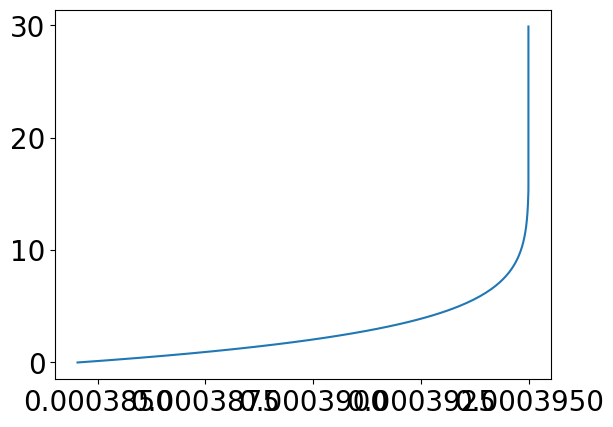

In [51]:
fig, ax = plt.subplots()
yplt = dat1['z']/1e3
xplt = dat1['xCO2']
ax.plot(xplt,yplt)